# Imports and initialisation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time
from IPython.display import clear_output
from tqdm import tqdm
from scipy.stats import kde
from smt.sampling_methods import LHS
from glob import glob

import multiprocessing
from joblib import Parallel, delayed


N_cores = multiprocessing.cpu_count()

import matplotlib
font = {'family' : 'Computer Modern',
        #'weight' : 'bold',
        'size'   : 11}

matplotlib.rc('font', **font)

In [21]:
# SIMULATION PARAMETERS
sigma = 2.928*1e-10
epsilon = 3.180*1e-3*scipy.constants.e


box_size = sigma*5 # half arm length of square

def V_LJ(r, sigma, epsilon):
    """
    Lennard Jones potential
    """
    return 4*epsilon*((sigma/r)**12-(sigma/r)**6)

def V_LJTS(r,sigma=sigma, epsilon=epsilon):
    """
    Truncated and shifted Lennard Jones potential.
    Typically r_end=2.5*sigma
    
    r : distance between two interacting particles
    epsilon : depth of potential well
    sigma : distance at which V=0 (i.e. particle size)
    """
    r_end = 2.5*sigma
    
    mask = r<=r_end # zero otherwise
    r = r*mask
    r[r==0] = np.nan # replace r>r_end with np.nan, we'll exclude these
    
    return V_LJ(r, sigma, epsilon)-V_LJ(r_end, sigma, epsilon)

# Lennard Jones Potential Truncated & Shifted

/var/folders/xp/866_6wxx269gtln73hn505vh0000gn/T/ipykernel_2346/3105785468.py:11: RuntimeWarning: divide by zero encountered in true_divide
  return 4*epsilon*((sigma/r)**12-(sigma/r)**6)
/var/folders/xp/866_6wxx269gtln73hn505vh0000gn/T/ipykernel_2346/3105785468.py:11: RuntimeWarning: invalid value encountered in subtract
  return 4*epsilon*((sigma/r)**12-(sigma/r)**6)


Text(0, 0.5, '$u^{\\mathrm{tr-sh}}(r) / \\epsilon$ [-]')

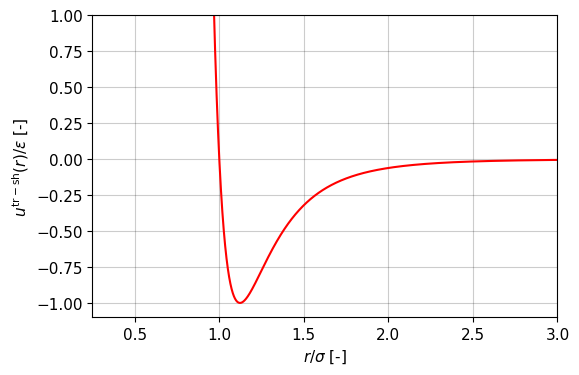

In [29]:
x = np.linspace(0*sigma,5*sigma, 10000)

V = V_LJTS(x)

plt.figure(dpi=100)
plt.plot(x/sigma,V/epsilon,'r-')
#plt.xscale('log')
#plt.yscale('log')
plt.grid(which="major", color='black', alpha=0.2)  # make the grid nice
plt.grid(which="minor", color='black', alpha=0.1)
plt.ylim(-1.1,1)
plt.xlim(0.25,3)

plt.xlabel(r"$r/\sigma$ [-]")
plt.ylabel(r"$u^{\mathrm{tr-sh}}(r) / \epsilon$ [-]")

#plt.savefig("LJ.png", dpi=300, transparent=True, bbox_inches='tight')

In [23]:
def dr_parallel(coords, indices, x, y):
    drs = []
    for i in indices:  # could make this parallel
        i = int(i)
        
        xi = coords[i, 0]
        yi = coords[i, 1]

        # distance in cartesian coordinates
        dr = np.sqrt((x-xi)**2+(y-yi)**2)
        dr[i] = np.nan  # exclude r_i - r_i

        dr = dr[~np.isnan(dr)]  # exclude the NaNs
        drs.append(dr)
    return np.array(drs)


def U(coords):
    """
    Return the potential energy of the coordinates configuration.
    """
    drs = []
    r = coords[:, 0]
    theta = coords[:, 1]

    indices = np.linspace(0, coords.shape[0]-1)
    indices = np.array_split(indices, N_cores*2)
    
    results = Parallel(n_jobs=N_cores*2)(delayed(dr_parallel)(
    coords, indices_, r, theta) for indices_ in indices) # execute in parallel
    drs = np.concatenate(results, axis=0)

    dr = drs.flatten()  # ||r_i,j||

    E_pot = V_LJTS(dr) # LJ values between particle i and all other particles

    return np.nansum(E_pot)  # potential energy of the configuration

In [24]:
# random step

def step(coords, max_step_size=sigma*5): # 
    """
    random step for every coordinate
    """
    coords = coords.copy()

    # random step in r
    dx = np.random.uniform(-1, 1, 1)*max_step_size
    dy = np.random.uniform(-1, 1, 1)*max_step_size

    i = np.random.randint(0, high=coords.shape[0])  # pick a random r_i
    
    coords[i,0] += dx
    coords[i,1] += dy
    
    # hard code PBC (i.e. particle flows through walls |-->  --|-->)
    if coords[i,0] > box_size:
        coords[i,0] = coords[i,0] - 2*box_size
    if coords[i,0] < -box_size:
        coords[i,0] = coords[i,0] + 2*box_size
        
    if coords[i,1] > box_size:
        coords[i,1] = coords[i,1] - 2*box_size
    if coords[i,1] < -box_size:
        coords[i,1] = coords[i,1] + 2*box_size
    
    return coords

In [25]:
def annealing(coords, T, dt, M, show_output=False, epsilon=epsilon):
    """
    coords: input array
    T: starting temperature
    dt: stepsize for delta T
    N: number of repetitions per dt
    """

    coords = coords.copy()
    Us = []
    Ts = []
    rnd_accepted=1
    rnd_rejected=1
    for i in tqdm(range(int(T/dt)+1)):
        if T-dt > 0:
            T += -dt
        else:
            break # not nicely written

        for m in range(int(M)):  # paper does this
            U_ = U(coords)
            Us.append(U_)
            Ts.append(T)
            #time.sleep(0.5)
            #print('-----')
            dcoords = step(coords)
            dE = U(dcoords) - U_
            
            if dE < 0: # book doesn't specify this? it is more efficient to do this.
                coords = dcoords.copy()
            else:    
                beta = 1/(scipy.constants.Boltzmann*T)
                p = np.exp(-dE*beta) # rescaled this to eV
                if np.random.uniform(0,1) <= min(1,p):
                    rnd_accepted+=1
                    # accept step
                    coords = dcoords.copy()
                else:
                    rnd_rejected+=1
                    

        if show_output:
            if i % 1000 == 0:
                print(rnd_accepted, rnd_rejected, rnd_accepted/rnd_rejected)
                clear_output(wait=True)
                plt.figure(dpi=300)
                plt.clf()
                plt.plot(coords[:, 1]/sigma, coords[:, 0]/sigma, 'r.', ms=2)
                plt.ylim([-box_size/sigma, box_size/sigma])  # r in [0,1]
                plt.xlim([-box_size/sigma, box_size/sigma])
                #plt.text(-box_size/sigma, box_size*1.1/sigma, "p = %.3e, T=%.1f, dE=%.3e, U = %.3f" % (p, T, dE, U_/scipy.constants.e))
                plt.xlabel(r"x / $\sigma$ [-]")
                plt.ylabel(r"y / $\sigma$ [-]")
                plt.grid()
                plt.savefig(f"T{T}.png", dpi=300, transparent=True, bbox_inches='tight')
                plt.show()

    return coords, Us, Ts

In [26]:
def experiment(Nsamples, N=5, T=1, dt=1e-2, M=100, show_output=False):

    result = []
    for _ in range(Nsamples):
        """ Initialize some random positions """
        # init some random positions
        #x = np.random.uniform(-1, 1, N)*box_size
        #y = np.random.uniform(-1, 1, N)*box_size
        
        
        # Orthogonal LHC sampling
        xlimits = np.array([[-1*box_size, 1*box_size], [-1*box_size, 1*box_size]])
        cube_design = LHS(xlimits=xlimits, criterion="correlation")
        c = cube_design(int(N))
        coords = np.stack((c[:,0],c[:,1]), axis=-1) # (N, coord)
        #coords = np.stack((x, y), axis=-1)  # (N, coord)

        """ simulated annealing """
        coords_, Us_, Ts_ = annealing(
            coords, T, dt, M, show_output)  # our minimized particles
        result.append(coords_)

    result = np.array(result)

    return result, Us_, Ts_  # np.concatenate(result, axis=0)

# Run an experiment here

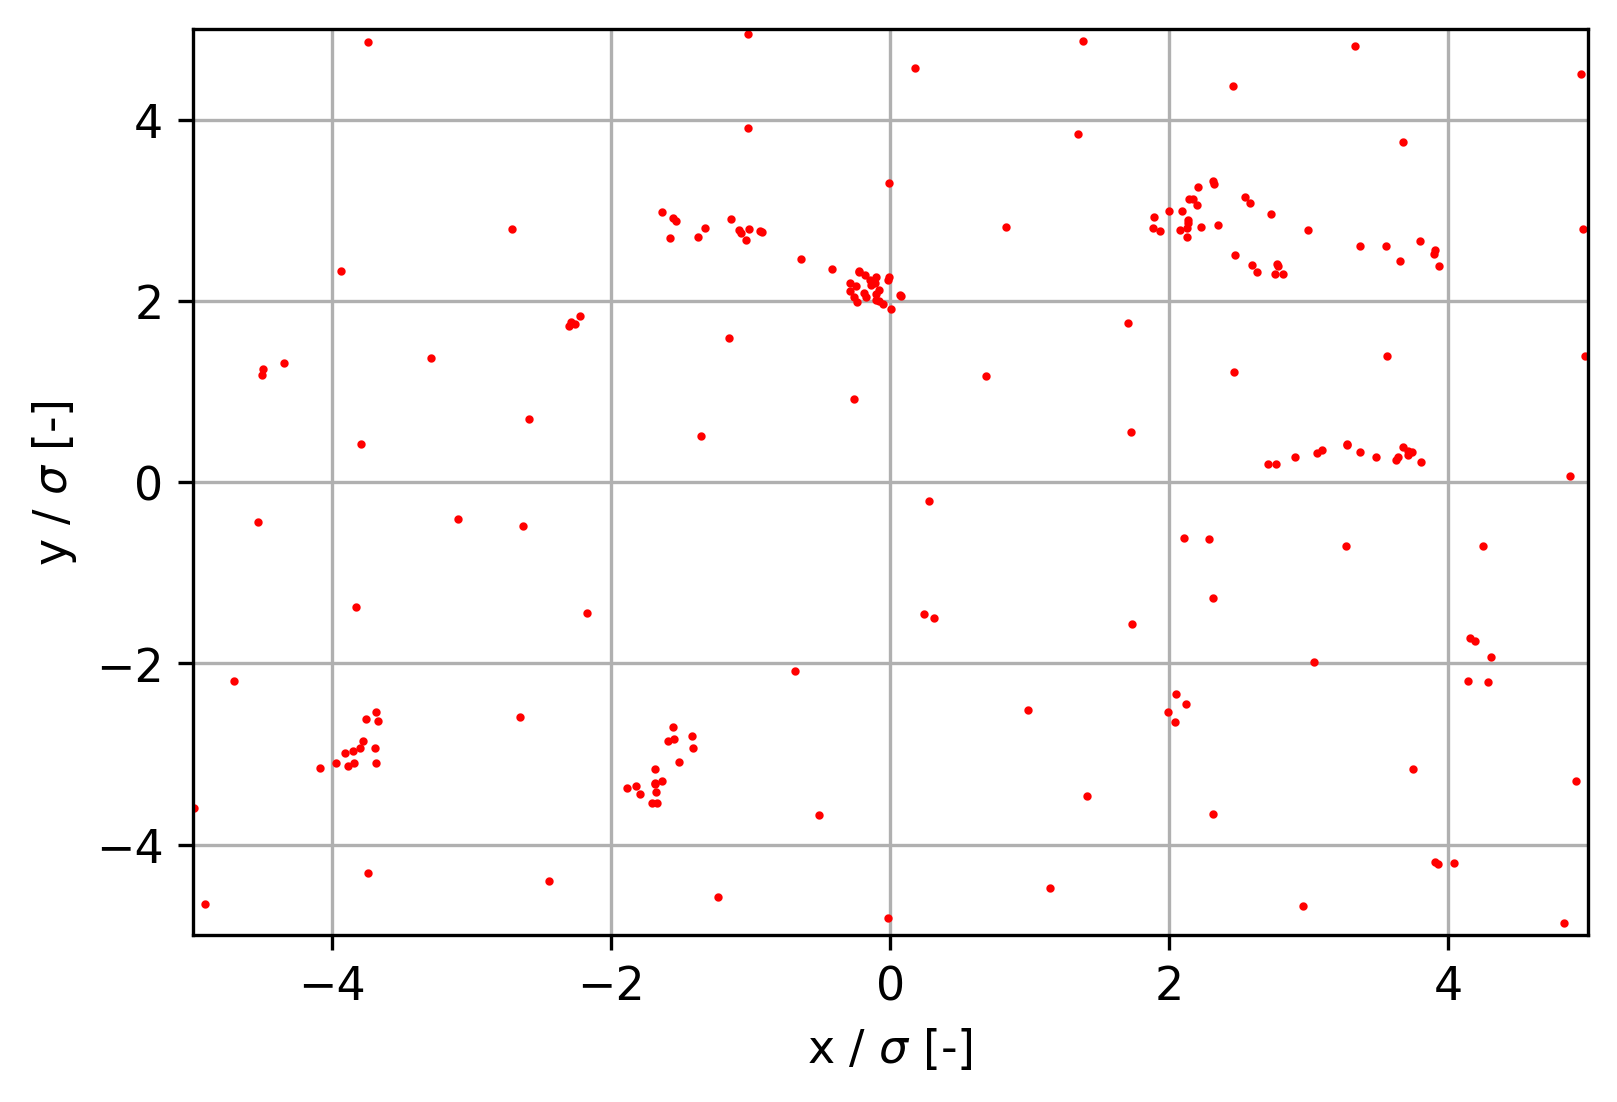

100%|████████████████████████████████████▉| 30000/30001 [06:23<00:00, 78.31it/s]


(1, 200, 2)

In [28]:
# T=15 beetje nucleatie

out, Us_, Ts_ = experiment(1, N=200, T=30, dt=1e-3-1e-10, M=1, show_output=True) # it works, but the Temperature cooling is shit.
out.shape

In [9]:
Ts_ = np.array(Ts_)
Us_ = np.array(Us_)

#Us_

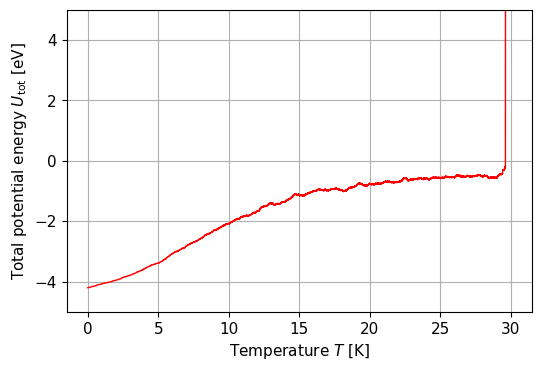

In [16]:
plt.figure(dpi=100)
plt.plot(Ts_, Us_/scipy.constants.e, 'r-', lw=1, ms=1.0)
plt.ylabel(r"Total potential energy $U_\mathrm{tot}$ [eV]")
plt.xlabel(r"Temperature $T$ [K]")
#plt.xscale('log')
#plt.yscale('symlog') # symmetic log scale (i.e. both sides)
#plt.xlim([0, 100])
plt.ylim([-5, 5])
plt.grid()
#plt.savefig(f"U.png", dpi=300, transparent=True, bbox_inches='tight')

In [11]:
np.logspace(-6, 6, 10)

array([1.00000000e-06, 2.15443469e-05, 4.64158883e-04, 1.00000000e-02,
       2.15443469e-01, 4.64158883e+00, 1.00000000e+02, 2.15443469e+03,
       4.64158883e+04, 1.00000000e+06])

In [12]:
# Lets instantiate some random positions

N = 5  # n particles
T = 1e-2  # start temp
# dt = 1e-4 # dt
M = 10  # iterations per dt

Nsamples = int(100 / N_cores)
variable = np.logspace(-4, 1, 5)
# for T in variable:
dt = T/1000
print(T, dt)
results = Parallel(n_jobs=N_cores)(delayed(experiment)(
    Nsamples, N, T, dt, M) for _ in range(N_cores))
results = np.array(results)
results = np.concatenate(results, axis=0)
results.shape  # (Nsamples, Nparticles, coords)

# plot the result
plt.figure(dpi=100)
plt.polar()  # init polar plot
Us = []
for coords in tqdm(results):
    plt.plot(coords[:, 1], coords[:, 0], 'r.', ms=10, alpha=0.1)
    Us.append(U(coords))
Us = np.array(Us)
plt.title("T=%.2e, dt=%.2e, U=%.2e +- %.2e" % (T, dt, Us.mean(), Us.std()))
plt.ylim([0, 1])  # r in [0,1]
#plt.savefig("figures//T_dt_scan_OLHC_Tis%s.png" % T, dpi=300, transparent=True, bbox_inches='tight')
plt.show()
#np.save("figures//T_dt_scan_OLHC_Tis%s.png" % T, results)

0.01 1e-05


 59%|█████▉    | 590/1000 [01:15<00:52,  7.85it/s]
Exception in thread Thread-609103:
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.9/3.9.9/Frameworks/Python.framework/Versions/3.9/lib/python3.9/threading.py", line 973, in _bootstrap_inner
 60%|█████▉    | 597/1000 [01:12<00:49,  8.19it/s]
    self.run()
  File "/opt/homebrew/Cellar/python@3.9/3.9.9/Frameworks/Python.framework/Versions/3.9/lib/python3.9/threading.py", line 910, in run
 61%|██████    | 609/1000 [01:14<00:48,  8.14it/s]
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/Cellar/python@3.9/3.9.9/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/pool.py", line 592, in _handle_results
    cache[job]._set(i, obj)
  File "/opt/homebrew/Cellar/python@3.9/3.9.9/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/pool.py", line 776, in _set
    self._callback(self._value)
  File "/opt/homebrew/lib/python3.9/site-packages/joblib/parallel.py", line 

KeyboardInterrupt: 

In [ ]:
# make one dataset to plot
all_coords = np.concatenate(results)

r = all_coords[:, 0]
phi = all_coords[:, 1]

x = r*np.cos(phi)
y = r*np.sin(phi)


# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins = 500
k = kde.gaussian_kde([x, y])  # gaussian kernel density estimator
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]  # bins
zi = k(np.vstack([xi.flatten(), yi.flatten()]))  # density value

# Make the plot
plt.figure(dpi=100)
plt.plot(x, y, '.', alpha=0.2, color='BLACK')
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto',
               cmap='jet')  # RdYlBu, bone, binary, magma

plt.colorbar(label="kde")
plt.xlabel(r"x")
plt.ylabel(r"y")
plt.xlim([-1, 1])
plt.ylim([-1, 1])
#plt.savefig("figures//N5.png", dpi=300, transparent=True, bbox_inches='tight')